# Ensemble learning

## Weighted
Sử dụng kết hợp nhiều model và kết hợp lại thành 1 meta-model:
- Với regression: Average outcome
- Với Classification: majority label


## Bagging

Xây dựng các models cùng lại nhưng train trên các subsamples khác nhau từ raw-sample, các subsample này được sinh ra từ phương pháp __bootstraping with replacement__. 

Các model này độc lập và song song với nhau, kết quả cuối cùng sử dụng trung bình cộng các decision rules hoặc `majority class`

--> Mục tiêu là giảm __variance__ - áp dụng cho các model đã có sẵn __bias thấp__ và đang bị __variance cao__

### Random Forest
RF ngoài việc tạo __bootstrap with replacement subsample by records__ từ raw sample thì còn thực hiện __bootstrap without replacement by variables__

Tuy nhiên FR là 1 blackbox model, khác với simple decision tree.

--> giúp giải quyết vấn đề khi input đầu vào thiếu 1 số features (chứa nan và không muốn imputation)

__1. out of bag score (oob)__
- __OOB sample__ là tập obs không nằm trong tập train (dc bootstrap trong total obs) của mỗi single tree.
- __OOB score__ là một cách validate RF model, thông qua tính tỷ lệ obs trong oob sample dc dự đoán đúng bởi single tree tương ứng. ví dụ: `xi` không thuộc tập train của các tree `DT1`, `DT2`,... ,`DTn`, sẽ được dự báo bởi các tree này, nếu majority voting == real labels ---> xi là 1 obs predict đúng. làm tương tự vs các obs khác và tính tỷ lệ predict đúng.
- __OOB error__ = 1 - __OOB score__: thể hiện tỷ lệ obs oob dự đoán sai.

OOB error is a way similar a validation score but in __smaller dataset__(not suitable for split train + val dataset), check the error rate change by number of estimator


![image.png](_images/4_ML_Algorithms/oob.png)

__2. Variable Importance__ (`model.feature_importances_`)

- **decrease in accuracy of the model**: Mức độ giảm độ chính xác của model thông qua oob_score nếu biến này được hoán đổi random value giữa các records 1 cách ngẫu nhiên. Nếu mức decrease in accuracy càng lớn thì biến đó bằng quan trọng.

![image.png](_images/4_ML_Algorithms/de_acc_rf.png)

- **Giá trị giảm trung bình của gini impurity score**: TÍnh mức độ giảm điểm Gini impurity score trên node khi có biến đó được sử dụng, tính toán trên bộ train data, thay vì tính điểm oob trên validation data nên kém chính xác hơn. Tuy nhiên, pp này hiệu quả về mặt tính toán nếu sử dụng nhiều cây, hơn nữa còn show ra được các biến model đang coi là importance thay vì các biến kiểm tra từ tệp bên ngoài.

gini decrease: `model.feature_importances_ `

![image.png](_images/4_ML_Algorithms/de_gini_rf.png)

__3. Tunning hyperparameter__
- `nodesize`: tăng nodesize giảm overfitting
- `min_samples_leaf`:
- `maxnodes` = 2 * `max_leaf_nodes` - 1 = Số lượng node tối đa cho mỗi 1 decision tree 

In [19]:
from sklearn.datasets import load_wine
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [20]:
X, y = load_wine(return_X_y =True, as_frame=True)
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [25]:
rfc = RandomForestClassifier(
    n_estimators=100, # The number of trees in the forest.
    criterion='gini', # Function to measure quality of split {“gini”, “entropy”, “log_loss”}
    max_depth=None, # max depth of single tree, higher is more overfitting 
    min_samples_split=2, # Số sample tối thiểu cần có để tiếp tục thực hiện split, 
                            # nếu sample ít hơn, thực hiện assign class bằng probability lớn hơn.
    min_samples_leaf=1, # Số sample tối thiểu của 1 leaf, sẽ không tạo ra các leaf có số sample trong leaf ít hơn
    min_weight_fraction_leaf=0.0,
    max_features='sqrt', # The number of features to consider when looking for the best split
    max_leaf_nodes=None, # Số lượng node tối đa cho mỗi 1 decision tree
    min_impurity_decrease=0.0,
    bootstrap=True,
    oob_score=True, # use out-of-bag samples to estimate the generalization score
    n_jobs=None,
    random_state=None,
    verbose=0,
    warm_start=False,
    class_weight=None,
    ccp_alpha=0.0,
    max_samples=None, # If bootstrap is True, the number of samples to draw from X to train each base estimator
)

rfc.fit(X_train, y_train)
rfc.score(X_test, y_test)

0.9555555555555556

In [26]:
# oob score
print('oob score = ',rfc.oob_score_)

# oob error
print('oob error = ',1 - rfc.oob_score_)

oob score =  0.9699248120300752
oob error =  0.03007518796992481


__Feature importance based on mean decrease in impurity__

Warning: Impurity-based feature importances can be misleading for high cardinality features (many unique values)

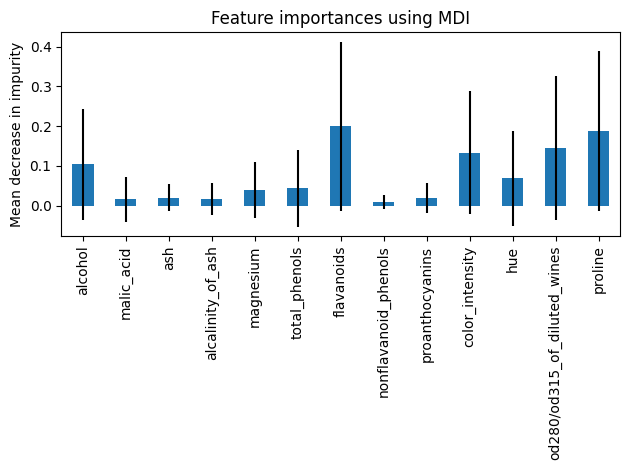

In [32]:


import pandas as pd
import numpy as np
import matplotlib. pyplot as plt

importances = rfc.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc.estimators_], axis=0)
forest_importances = pd.Series(importances, index=X.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

__Feature importance based on feature permutation__

Permutation feature importance overcomes limitations of the impurity-based feature importance: they do not have a bias toward high-cardinality features and can be computed on a left-out test set.

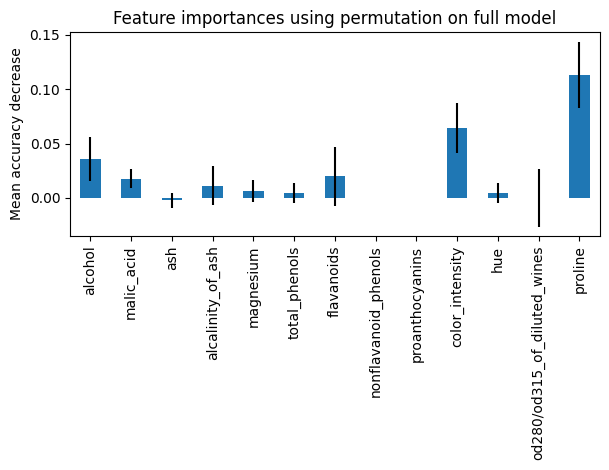

In [34]:
from sklearn.inspection import permutation_importance

result = permutation_importance(rfc, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)
forest_importances = pd.Series(result.importances_mean, index=X.columns)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

### Extremely Randomized Trees (extra-tree)
Tương tự như random forest, khác ở điểm thay vì chọn ngưỡng tối ưu để split (cut-off split point) ở node như RF thì sẽ chọn ngẫu nhiên ở ET.
- Thuật toán chạy nhanh hơn so với RF, nên phù hợp với dữ liệu lớn hơn

In [37]:
from sklearn.ensemble import ExtraTreesClassifier
etc = ExtraTreesClassifier().fit(X_train, y_train)
etc.score(X_test, y_test)

0.9555555555555556

### Bagging meta-estimator
Sử dụng estimator bất kỳ cho phương pháp bagging

In [35]:
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
bagging = BaggingClassifier(KNeighborsClassifier(),
                            max_samples=0.5, max_features=0.5)

## Boosting

Xây dựng các model cùng loại, mỗi model sau sẽ dự đoán error của model trước, tạo thành chuỗi model mà model sau sẽ tốt hơn model trước.

--> Mục tiêu là giảm bias - áp dụng cho các model có variance thấp và bị bias cao

- Boosting là một quá trình tuần tự, không thể xử lí song song, do đó, thời gian train mô hình có thể tương đối lâu.
- Sau mỗi vòng lặp, Boosting có khả năng làm giảm error theo cấp số nhân.
- Boosting sẽ hoạt động tốt nếu base learner của nó không quá phức tạp cũng như error không thay đổi quá nhanh.
- Boosting giúp làm giảm giá trị bias cho các model base learner.

### AdaBoost
Thuật toán tổng hợp các submodel theo trọng số trên toàn bộ data với model sau được build trên data đã được re-weighting với idea trên model trước đó, data point nào gây ra error lớn thì có weight cao hơn và ngược lại.

Tuy nhiên với dữ liệu có large error (bias) thì Gradient Boosting hiệu quả hơn

- AdaBoost can be used both for classification and regression problems

**Procedure**

1. Khởi tạo ban đầu với tham số 
- $M$ là số lượng submodels, 
- weight của $N$ data point ban đầu $w_0 =\frac{1}{N}$, 
- final model ban đầu $F_0$ = 0.

2. Tại vòng lặp thứ i:
- Train model $f_i$ để lấy được `minimizes weighted error` $\epsilon_i$ = tổng các trọng số $w_i$ của các data point bị misclassified (dự đoán bị sai). 
- Tính trọng số `model_i` theo công thức: $\alpha_i = 0.5*\ln(\frac{1}{\epsilon_i} -1)$
- Cập nhật $w_{i+1}$ cho $N$ datapoint model tiếp theo: 
$w_{i+1(n)} = w_i * e^{- y_n * \alpha_i * f_i(x_n)} $ cho datapoint thứ n
- Chuẩn hoá $w_{i+1}$ bằng cách chia cho tổng $w_{i+1}$ sao cho tổng của chúng = 1
- Cập nhật final model: $F_i = F_{i-1} + \alpha_i * f_i$
- Output khi chạy model là $H = sign(F_M)$
    
FYI: AdaBoost có thể được áp dụng mà không cần dựa vào việc đánh trọng số lại các điểm dữ liệu, thay vào đó, chúng ta có thể re-sample để lấy dữ liệu train cho các model tiếp theo dựa vào xác suất được xác định bới các trọng số.

In [39]:
from sklearn.ensemble import AdaBoostClassifier

clf = AdaBoostClassifier(    
    estimator=None, # thuật toán kết hợp với pp adaboost, mặc định là decision tree
    n_estimators=50, # số lượng tối đa estimators sử dụng, nếu vượt quá thì ko quá trình boosting nữa
    learning_rate=1.0, # hệ số learning rate
)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.8666666666666667

### Gradient Boosting
Tương tự như cách hoạt động của adaboost, thay vì cập nhật weight các features thì gradient boosting cập nhật `model mới` = `model cũ` + `pseudo-residuals`

Model tiếp theo sẽ fit vào `pseudo-residuals` của model trước đó
$M_{n}=M_{n-1}-\eta{\frac{\partial}{\partial m}}L(M_{n-1})$

### XGBoost
Base trên gradient boosting nhưng cải tiến về mặt thuật toán, kết hợp cả GPU và CPU
- XGBoost có thể được sử dụng để giải quyết được tất cả các vấn đề từ hồi quy (regression), phân loại (classification), ranking và giải quyết các vấn đề do người dùng tự định nghĩa.
- Engineering để tránh overfitting như: sub-sampling row, column, column per split levels, áp dụng regularized L1 và L2.
- Khả năng tận dụng tài nguyên hệ thống: tính toán song song trên CPU/GPU, tính toán phân tán trên nhiều server, tính toán khi tài nguyên bị giới hạn, cache optimization để tăng tốc training.
- Và cuối cùng là khả năng xử lý missing data value, tiếp tục training bằng mô hình đã được build trước đó để tiết kiệm thời gian.

__1. Avoid overfitting__
Overfitting in XGB có thể dẫn tới predict dữ liệu chưa có trong tập train có thể giảm độ chính xác và kết quả dự đoán có high variance, unstable. Các pp giảm overfitting:
- __Cross-validation__
- __Regularization__: Sử dụng penalty (L1 hoặc L2) cho cost function. Increasing `alpha` or `lambda` will penalize more complex models and reduce the size of trees that are fit 
    - `reg_alpha` : Manhattan distance (L1 regu)
    - `reg_lambda` : squared Euclidean dítance (L2 regu)
- __Early stopping__:
- __Reduce number of trees__:
- __Reduce number of features selection__:

__2. Hyperparameters__
- `eta/learning_rate`: the alpha in The Boosting Algorithm, if the data has more noisy, reduce the `lr`
- `max_depth`: the maximum depth of leaf, lower maxdepth helps reduce overfitting
- `nrounds/n_estimators`: số lượng tối đa estimators sử dụng (boosting rounds). Nếu lr thấp, nên set n_estimators cao do quá trình học chậm, update ít.
- `subsample`: tỷ lệ %rawsample without replacement cho mỗi 1 round model, để thấp tránh được overfitting
- `colsample_bytree`: tỷ lệ %features use for each round model, để thấp tránh được overfitting, hỗ trợ cho TH input predict bị thiếu feature
- `lambda/reg_lambda` and `alpha/reg_alpha`: Hệ số alpha (Lasso - L1) và lambda (Ridge-L2) cho regularization

In [55]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.datasets import load_breast_cancer

X, y = load_breast_cancer(return_X_y = True, as_frame = True)
X_train, X_test, y_train, y_test = train_test_split(X, y)
eval_set = [(X_train, y_train), (X_test, y_test)]

param_grid = {
  "objective": ["binary:logistic"], 
  "booster": ["gbtree"], 
  "max_depth": [3 ] , #[3, 5, 7], # default: 3 only for depthwise
  "n_estimators": [20] , # [500, 1000], # default: 500  
  "learning_rate": [0.05 ] , # [0.1, 0.05, 0.01], # default: 0.05 
  "subsample": [0.6] , #  [0.6, 0.8], 
  "colsample_bytree": [0.6] , #  [0.6, 0.8],
  "colsample_bylevel": [0.6] , #  [0.6, 0.8],
  "random_state": [1],
  'min_child_weight': [11], 
  "eval_metric": ["auc"], 
}
cv=StratifiedKFold(n_splits=4, shuffle=True, random_state=1)

xgb_model = xgb.XGBClassifier()

grid_search = GridSearchCV(xgb_model, param_grid, n_jobs=2, 
                        cv = cv, scoring='roc_auc', verbose=1)

grid_result = grid_search.fit(X_train, y_train, verbose = 0, eval_set=eval_set)
print("Best Score: ", grid_result.best_score_)

Fitting 4 folds for each of 1 candidates, totalling 4 fits
Best Score:  0.9807611853320808


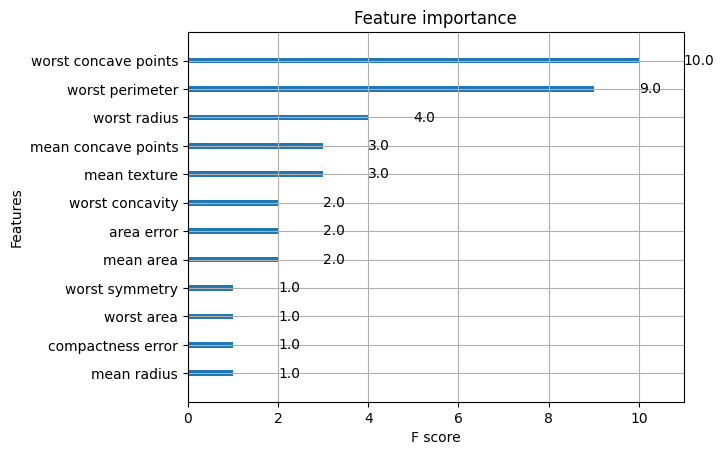

In [47]:
# default plot_importance
from xgboost import plot_importance
plot_importance(grid_search.best_estimator_)
plt.show()

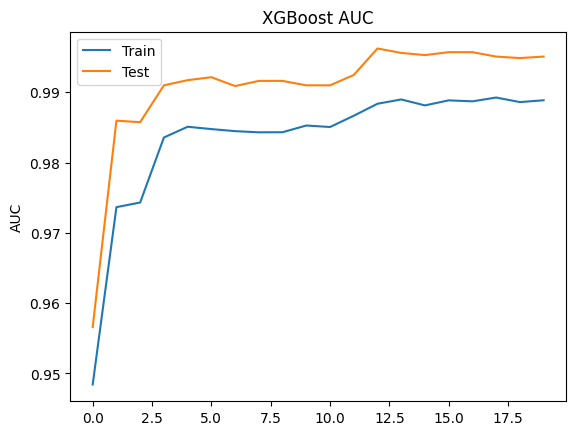

In [56]:
# evaluation plot
# retrieve performance metrics 
results = grid_search.best_estimator_.evals_result()
epochs = len(results['validation_0' ]['auc'])
x_axis = range(0, epochs)
 
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['auc'], label='Train')
ax.plot(x_axis, results['validation_1']['auc'], label='Test')
ax.legend()
plt.ylabel('AUC')
plt.title('XGBoost AUC')
plt.show()

### LightGBM

__LightGBM__ sử dụng "histogram-based algorithms" thay thế cho "pre-sort-based algorithms " thường được dùng trong các boosting tool khác để tìm kiếm split point trong quá trình xây dựng tree. Cải tiến này giúp LightGBM tăng tốc độ training, đồng thời làm giảm bộ nhớ cần sử dụng. Cả xgboost và lightgbm đều sử dụng histogram-based algorithms, điểm tối ưu của lightgbm so với xgboost là ở 2 thuật toán: GOSS (Gradient Based One Side Sampling) và EFB (Exclusive Feature Bundling) giúp tăng tốc đáng kể trong quá trình tính toán. Chi tiết về GOSS và EFB, các bạn có thể đọc thêm tại: https://towardsdatascience.com/what-makes-lightgbm-lightning-fast-a27cf0d9785e

__LightGBM__ phát triển tree dựa trên __leaf-wise__, trong khi hầu hết các boosting tool khác (kể cả `xgboost`) dựa trên __level-wise__. 
- __Leaf-wise__ phát triển tree theo node đang xét cho hết node đó rồi mới nhảy sang node tiếp theo ==> nên sử dụng `maxdepth` để tránh overfitting. 
- __Leaf-wise__ lựa chọn nút để phát triển cây dựa trên tối ưu toàn bộ tree, trong khi __level-wise__ tối ưu trên nhánh đang xét (__level-wise__: phát triển theo tầng của tree, khi phát triển hết tầng thì mới nhảy xuống tầng tiếp theo.), do đó, với số node nhỏ, các tree xây dựng từ __leaf-wise__ thường out-perform __level-wise__.

Note: Leaf-wise tuy tốt, nhưng với những bộ dữ liệu nhỏ, các tree xây dựng dựa trên leaf-wise thường dẫn đến overfit khá sớm. Do đó, lightgbm sử dụng thêm 1 hyperparameter là maxdepth nhằm cố gắng hạn chế điều này. Dù vậy, LightGBM vẫn được khuyến khích sử dụng khi bộ dữ liệu là đủ to.

__Lựa chọn LightGBM thay cho XGBoost__:
- Dữ liệu lớn
- Nhiều categorical features
- Ưu tiên tốc độ hơn performance model
- Khắc phục vấn đề training lâu cho dữ liệu lớn của XGboost

## Stacking

Xây dựng các base-model khác loại train trên cùng 1 bộ dữ liệu tạo thành 1 meta model, train các model này độc lập sau đó sẽ tìm cách kết hợp/ hoặc xây dựng 1 metamodel để predict output từ input là output của các base-model

--> Mục tiêu là giảm bias - áp dụng cho các model có variance thấp và bị bias cao

**1. Level-model**
- __Level 0 (base model)__: Mô hình cơ sở học trực tiếp từ bộ dữ liệu và đưa ra dự đoán cho mô hình level-1
    - Các base-models có những cách học khác nhau trên bộ dữ liệu, cho nên outputs hay errors của các base-models là không tương quan (uncorrelated) hay có độ tương quan thấp (low correlation).
    - Đầu ra của base-models có thể là giá trị thực (cho bài toán Hồi quy) hoặc là các xác suất của nhãn trong bài toán phân loại.
    - Base-models thường phức tạp và đa dạng, mỗi mô hình có cách học và giải quyết vấn đề khác nhau với cùng một bài toán như: Decision Tree, SVM, Neural Network,... và kể cả là các thuật toán ensemble khác như GBM, Random Forest,...
- __Level 1 (meta model)__:Mô hình học từ các dự đoán của mô hình cơ sở (level-0) hoặc có thể kết hợp thêm input của base model, Meta-model thường đơn giản:
    - Linear Regression cho bài toán Regression -> Trả về số thực
    - Logistic Regression cho bài toán Classification -> Trả về xác suất các label
    
**Thuật toán stacking**
- Khởi tạo ban đầu:
    - Dataset = Train + Test
    - Train = k-fold
    - Set base-models (M) - level 0
    - Strong-model (H) - level 1
- Với mỗi base-model (m) trong set base-models (M):
    - Với mỗi fold, train model m trong k-1 fold còn lại và predict fold đó. Sau k vong lặp, thu được k-fold predicted từ k model (cùng 1 base-model) mà kết quả predict này không xuất hiện để train model (tránh được overfitting).  k-fold predicted này sẽ sử dụng làm 1 feature trong train-dataset cho model H.
    - Lấy toàn bộ dữ liệu trong train data để train model thứ k+1 (cùng base-model) và predict test data, kết quả thu được làm 1 feature trong test-dataset cho model H
- Lặp lại với các M-1 base model khác thu được tổng cộng M feature của train và M feature của test dataset cho model H

Một số biến thể trong cách triển khai:
- Kết hợp 1 số features của base-model + predicted base-model = tranining dataset của meta-model
- Thay vì sử dụng toàn bộ train dataset để build base-model thứ k+1 và predict test dataset thì sử dụng k-model từ k-fold để predict luôn test dataset, thu được k bộ dự đoán về test dataset. Phương pháp tổng hợp kết quả của k bộ dự đoán test dataset là nếu bài toán regression thì dùng mean, Nếu bài toán Classification thì cùng max-voting
- Multi-levels Stacking: Tăng thành 3 level model, tuy nhiên không sử dụng k-fold, thì số lượng dữ liệu cần dùng là rất nhiều, vì hiện tượng overfitting rất dễ xảy ra, nhưng nếu sử dụng k-fold, thì thời gian huấn luyện là cực kì tốn kém.

**Stacking family**
___1. Voting ensemble___

Thay vì sử dụng 1 meta-model (level 1) thì sử dụng các phương pháp lựa chọn output đơn giản hơn:
- Trong bài toán Regression, Voting đưa ra mean hoặc median của các predictions từ các base-models
- Trong bài toán Classification, Voting sẽ sử dụng Hard-voting (Class được predicted nhiều nhất) hoặc Soft-voting (Class có tổng xác suất được predicted là cao nhất)
Trong Voting, tất cả các base-models được giả định có cùng độ quan trọng như nhau, cùng hiệu năng như nhau, 

___2. Weighted Average Ensemble___

Điều chỉnh Voting ensemble bằng việc thêm weighted cho base-model dựa trên độ chính xác hoặc tự build 1 process để tối ưu trọng số

___3. Blending Ensemble___

Thay đổi stacking bằng cách thay vì sử dụng cross-validation ở training set thì chia training set thành `train set` + `validation set`:
- `Trainset` dùng để train base model, sau đó predict tại `validationset`
- `Validationset` + prediction `validationset` (base-model) sẽ làm input (__set1__) cho meta-model
- `Test set` và các kết quả dự đoán trên `test set` của các base models được sử dụng như là `test set` (__set2__) của blending model.
- Train và đánh giá blending model sử dụng __set1__ và __set2__.

___4. Super Learner Ensemble___

![image.png](_images/4_ML_Algorithms/SuperLearnerEnsemble.png)

In [59]:
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split

# load data
X_train, X_test, y_train, y_test = train_test_split(*load_diabetes(return_X_y=True))

# setup base model (level 0)
estimators = [('ridge', RidgeCV()),
              ('lasso', LassoCV(random_state=42)),
              ('knr', KNeighborsRegressor(n_neighbors=20,
                                          metric='euclidean'))]

# setup meta model (level1)
# The final_estimator will use the predictions of the estimators as input
final_estimator = GradientBoostingRegressor(n_estimators=25, subsample=0.5, 
                                            min_samples_leaf=25, max_features=1,)
reg = StackingRegressor(estimators, final_estimator)
reg.fit(X_train, y_train)

reg.score(X_test, y_test)

0.42738455065984304

In [62]:
# multi layer stacking

from sklearn.ensemble import RandomForestRegressor

multi_layer_regressor = StackingRegressor(
    estimators=[('ridge', RidgeCV()),
                ('lasso', LassoCV()),
                ('knr', KNeighborsRegressor(n_neighbors=20,
                                            metric='euclidean'))],
    final_estimator=StackingRegressor(
        estimators=[('rf', RandomForestRegressor(n_estimators=10, max_features=2)),
                    ('gbrt', GradientBoostingRegressor(n_estimators=10, max_features=2))],
        final_estimator=RidgeCV()
    )
)
multi_layer_regressor.fit(X_train, y_train)
multi_layer_regressor.score(X_test, y_test)

0.41430511335119347